In [2]:
import numpy as np
import matplotlib.pyplot as pl
import time

In [3]:
from varname import nameof, argname
def copier(arg):
    og_name = argname('arg')
    new_name = og_name + '_copy'
    globals()[new_name] = arg

In [4]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [34]:
f0 = 120
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal

In [35]:
beta

2.7439303219997145e-07

Generating signal and adding noise

In [36]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 50
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [37]:
# np.savez('./Realisations/beta=%.2e_Realisation0' % beta, data)

In [38]:
beta = 2.74e-07
data = np.load('./Realisations/beta=%.2e_Realisation0.npz' % beta)['arr_0']

In [39]:
%reset_selective -f "^signal$"
# %reset_selective -f noise
%reset_selective -f phi

In [40]:
# freqs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]-t[0]))
# fft = np.fft.fftshift(np.fft.fft(data))
# freqs = freqs[len(freqs)//2:]
# fft = fft[len(fft)//2:]

In [41]:
# pl.plot(freqs, np.abs(fft)/nt)
# pl.xlim(0, 200)

In [42]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [43]:
f_ratio = 25
out, t_out = strobo(beta, data, f_ratio)
corrected = np.fft.fftshift(np.fft.fft(out))
freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
corrected = corrected[len(corrected)//2:]
freq_corrected = freq_corrected[len(freq_corrected)//2:]
nt_new = len(out)

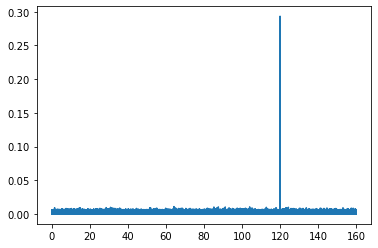

In [47]:
pl.plot(freq_corrected, np.abs(corrected/nt_new)**2)

## Numerically estimating error

In [104]:
def power_calc(beta):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    corrected = corrected[len(corrected)//2:]
    freq_corrected = freq_corrected[len(freq_corrected)//2:]
    resampled_power = np.abs(corrected/len(out))**2
    
    arg_max = np.argmax(resampled_power)
    peak_freq = freq_corrected[arg_max]
    peak_power = resampled_power[arg_max]
    return peak_freq, peak_power

In [105]:
ref_freq, ref_power = power_calc(beta)
power_calc((1+1e-2)*beta)

(119.99961121475691, 0.06918189266874951)

In [101]:
def inspecting(beta):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    corrected = np.fft.fftshift(np.fft.fft(out))
    freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
    corrected = corrected[len(corrected)//2:]
    freq_corrected = freq_corrected[len(freq_corrected)//2:]
    resampled_power = np.abs(corrected/len(out))**2
    
    arg_max = np.argmax(resampled_amplitudes)
    peak_freq = freq_corrected[arg_max]
    peak_power = resampled_power[arg_max]
    return freq_corrected, resampled_power

In [102]:
freq_corrected, resampled_power = inspecting((1+1e-2)*beta)

(119.9, 120.1)

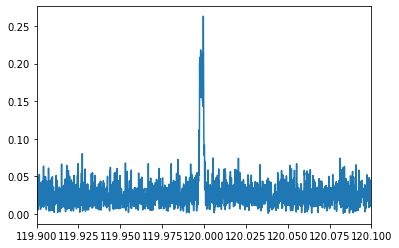

In [103]:
pl.plot(freq_corrected, resampled_amplitudes)
pl.xlim(119.9, 120.1)

In [49]:
tic = time.time()
offset_arr = np.logspace(-8, -7, 20)
ref_freq, ref_power = power_calc(beta)

offset_results = np.array([power_calc(beta+i*beta) for i in offset_arr])
toc = time.time()
print((toc-tic)/60)

1.3332523266474405


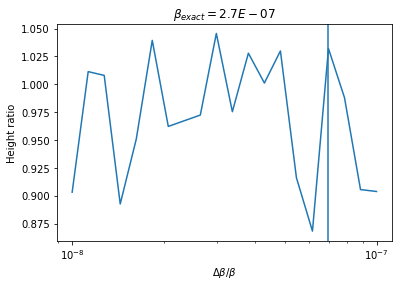

In [53]:
pl.semilogx(offset_arr, offset_results[:,1]/ref_power)
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
# pl.axvline(offset_arr[16], c='r')

#Large jump between index 15 and 16

In [106]:
freq_ref, power_ref = inspecting(beta)
freq_corrected0, resampled_power0 = inspecting((1+offset_arr[15])*beta)
freq_corrected1, resampled_power1 = inspecting((1+offset_arr[16])*beta)
freq_incorrect, power_incorrect = inspecting(10*beta)

In [107]:
print('%.2f' % max(resampled_power/ref_power), '%.2f' % max(resampled_power/ref_power))
print("These are the identified indices with the jump")

0.24 0.24
These are the identified indices with the jump


In [1]:
pl.plot(freq_ref, power_ref, label = 'exact beta')
pl.plot(freq_corrected1, resampled_power1, label = 'incorrect beta 1')
pl.plot(freq_corrected0, resampled_power0)
pl.plot(freq_incorrect, power_incorrect)
pl.axvline(freq_corrected0[np.argmax(resampled_power0)], c='r')

pl.xlim(119.999, 120.001)

NameError: name 'pl' is not defined

In [109]:
np.sum(resampled_power1)

1252.0276455122973

In [110]:
np.sum(resampled_power0)

1250.6411912582025

In [111]:
np.sum(power_ref)

1251.860990375777

In [112]:
np.sum(power_incorrect)

1251.3902467814187